I recently went to listen on a talk about doing Bayesian inference with PyMC3, delivered at the Boston Bayesians meetup by Thomas Wiecki. Given my current knowledge level about statistical modelling and such, I found that Thomas had delivered it at a level that I could understand and follow along. 

After the talk, I decided to go back and try a simple toy problem for myself, one that could be trivially solved by hand, but intentionally made complicated by the fancy tools (it's my way of learning the tools). 

This notebook is intended for a beginner Bayesian coder who gets linear algebra. It is my hope that the example used should appear trivial to you, yet be instructive for learning how to use PyMC3, and how you can use Bayesian inference in a practical way. Beyond that, I also hope this can serve as a recipe for building other Bayesian models, both for you (my reader) and myself.

Credits:

- I shamelessly copied Thomas Wiecki's blog post and reworked it to fit a linear regression problem. Inspiration credit goes to him.

In [1]:
%matplotlib inline
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons, make_regression

Firstly, I decided to set up a regression problem in which out of 3 features, only 1 was informative about the output. This can be set up by using `scikit-learn`'s built-in functions.

In [2]:
X, Y = make_regression(n_samples=100, n_features=3, n_informative=1, n_targets=1, noise=5)
X = scale(X)
Y = Y.reshape(Y.shape[0], -1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.9)

If we look at a scatter plot of all 3 features, we should be able to observe that this is indeed true.

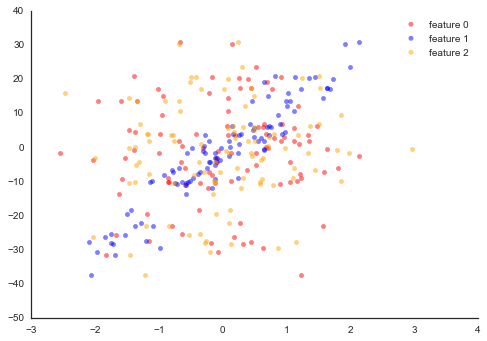

In [3]:
fig, ax = plt.subplots()
ax.scatter(X[:, 0], Y, color='r', label='feature 0', alpha=0.5)
ax.scatter(X[:, 1], Y, color='b', label='feature 1', alpha=0.5)
ax.scatter(X[:, 2], Y, color='orange', label='feature 2', alpha=0.5)
sns.despine()
ax.legend(loc='best')
plt.savefig('scatter.png')

We can then set up a simple model in PyMC3, where the output Y is simply a linear combination of each of the inputs X, and the goal is to estimate the distribution for each weight parameter.


```
Y = X.w + b
```

Here, `w` would be a vector of **w**eights of shape `(3, 1)`, while `b` would be a single scalar (of **b**ias) that shifts the values accordingly. As mentioned above, our goal here is estimate the distribution of each `w` value and `b`.

Placing myself in the shoes of an ignorant statistician, I will state my priors such that each of the weights `w[i]` and the bias `b` follows a Normal distribution with mean 0 and standard deviation 1. I could well use a different set of priors, and I would encourage you to change the priors below. 

*Note: a `Uniform` distribution between 0 and 1 would be making a strong assumption about the range of values that the weights could take on. On the other hand, using `w ~ U(-1000, 1000)` might be making a weaker assumption about the limits of `w`, but would still assume that `w` is limited to that range.*

*The `Normal` distribution makes no assumptions about the limits of its values, but it does make an assumption about the probability distribution of the values. Which prior is better? The best Bayesians will say, "get more data and it won't matter!"*

Following Thomas Wiecki's setup, we use Theano so that it's easy to swap in and out train/test values later on.



In [4]:
linreg_input = theano.shared(X_train)
linreg_output = theano.shared(Y_train)

with pm.Model() as linreg:
    weights = pm.Normal('weights', mu=0, sd=1, shape=(X.shape[1], Y.shape[1]))
    # weights = pm.Uniform('weights', 0, 1, shape=(X.shape[1], Y.shape[1]))
    biases = pm.Normal('biases', mu=0, sd=1, shape=(Y.shape[1]))
    
    output = pm.Normal('Y', T.dot(linreg_input, weights) + biases , observed=linreg_output)

And then, we run the ADVI algorithm implemented in PyMC3.

PyMC3 very helpfully displays the output, which shows the ELBO values converging on some small(er) negative value, indicating that the algorithm found a 'best fit' for the posterior distributions.

In [5]:
%%time

with linreg:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    v_params = pm.variational.advi(n=500000)

Iteration 0 [0%]: ELBO = -1089.05
Iteration 50000 [10%]: Average ELBO = -466.85
Iteration 100000 [20%]: Average ELBO = -195.3
Iteration 150000 [30%]: Average ELBO = -195.31
Iteration 200000 [40%]: Average ELBO = -195.32
Iteration 250000 [50%]: Average ELBO = -195.31
Iteration 300000 [60%]: Average ELBO = -195.31
Iteration 350000 [70%]: Average ELBO = -195.31
Iteration 400000 [80%]: Average ELBO = -195.31
Iteration 450000 [90%]: Average ELBO = -195.31
Finished [100%]: Average ELBO = -195.33
CPU times: user 42.1 s, sys: 834 ms, total: 42.9 s
Wall time: 43.6 s


We can plot the ELBO values as well.

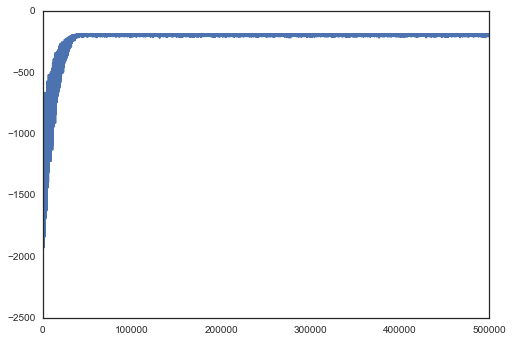

In [6]:
plt.plot(v_params.elbo_vals)
plt.savefig('elbo.png')

Using PyMC3's variational sampler, we can draw samples from the posterior distribution to visualize the uncertainty around each parameter.

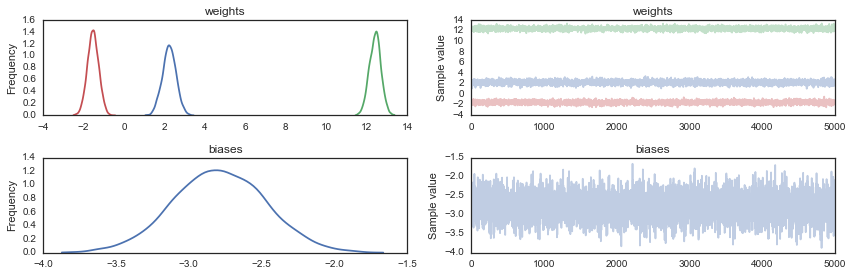

In [7]:
with linreg:
    trace = pm.variational.sample_vp(v_params, draws=5000)
    
pm.traceplot(trace)
plt.savefig('trace.png')

What we can see here is that just as expected, there is only one weight that is strongly informative, while the other two are weakly informative. The value also makes rough sense; basically all the Y-values are about 25-30X the X-values (see scatter plot above or predictions below) for the informative X.

Given the weights, we can also make predictions on a new set.

In [8]:
linreg_input.set_value(X_test)
linreg_output.set_value(Y_test)

ppc = pm.sample_ppc(trace, model=linreg, samples=10)

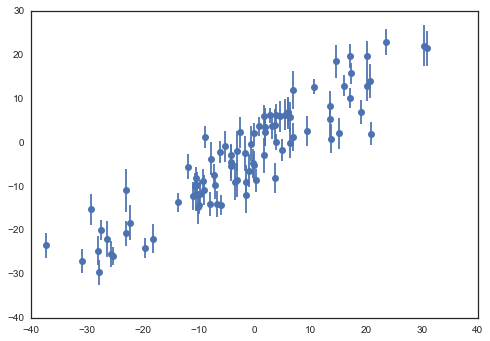

In [9]:
ycol = 0
ys = Y_test[:, ycol]
preds = ppc['Y'].mean(axis=0)[:, ycol]
yerr = ppc['Y'].std(axis=0)[:, ycol] * 3  # 3 standard deviations covers about 95% of the distribution
plt.errorbar(ys, preds, yerr=yerr, ls='none', marker='o')
plt.savefig('predictions.png')

Additionally, we can see a summary of the parameters' values and their uncertainties.

In [10]:
pm.summary(trace)


weights:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  ..............................[0, :]...............................
  2.235            0.339            0.005            [1.569, 2.894]
  ..............................[1, :]...............................
  12.415           0.288            0.004            [11.838, 12.965]
  ..............................[2, :]...............................
  -1.532           0.280            0.004            [-2.109, -1.013]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  .............................[0, :].............................
  1.573          2.014          2.238          2.464          2.903
  .............................[1, :].............................
  11.845         12.219         12.427         12.608         12.983
  ...

I think it's also valuable to visualize the weights values, just for visual confirmation.

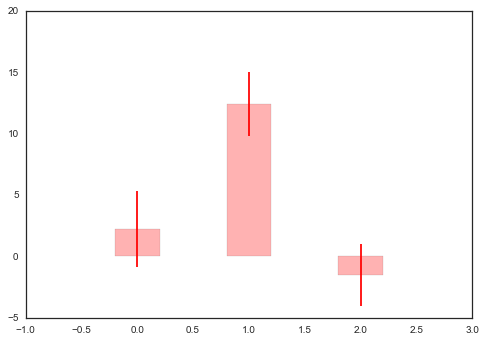

In [11]:
fig, ax = plt.subplots()
means = v_params.means['weights']
stds = v_params.stds['weights']
errors = stds * 3
barwidth = 0.4
plt.bar(np.arange(len(means))-barwidth/2, means[:, 0], color='r', width=barwidth, alpha=0.3)
plt.errorbar(np.arange(len(means)), means[:, 0], color='r', yerr=errors[:, 0]*3, ls='none')
plt.xlim(-1, 3)
plt.savefig('weights.png')

Indeed it's true that only one parameter is of an "informative" value, which is how we set up the problem to begin with. The other weight parameters are not very "informative" (i.e. not influencing to the final output Y), which means their magnitude is smaller than the "informative" parameter.

Okay, so this linear regression example was, actually, quite trivial. However, I think it's an instructive example for learning how to use PyMC3, and more generally, how Bayesian modelling can help us estimate parameter values and, more importantly, their *uncertainty*.

If you're interested in using this notebook to further your understanding of Bayesian modelling, I'd suggest trying out the following things:

1. Change the number of samples used for training.
    1. With just 10 samples in the training set, you may have noticed that the distribution is quite spread out.
    1. On the other hand, if you change the number of samples in the training set to 100, or even 1000, you will notice that the uncertainty around each parameter decreases dramatically.
1. I'd suggest trying out a different set of priors. What happesn if you limit the distribution range to not encompass the true values? (I have provided an example as a commented-out line of code.)
1. Try changing the input data by using a [non-linear regression problem](http://scikit-learn.org/stable/datasets/index.html), and then change the model specification from linear regression to some other non-linear regression model, e.g. neural networks.

The linear regression example can be extended to non-linear problems. For example, with neural networks (as in Thomas Wiecki's [example](http://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/), instead of directly matrix multiplying with linear weights, a matrix of weights is used (corresponding to the "nodes" of a neural network"), with an appropriately-shaped vector/matrix of biases.